In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
%matplotlib inline

In [2]:
df = pd.read_csv('tfidf_dataset.csv')
df.drop('Unnamed: 0', axis=1, inplace = True)

In [3]:
y = df['label']
X = df.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15)

In [4]:
train = X_train.to_numpy()
train = preprocessing.scale(train) 
test = X_test.to_numpy()
test = preprocessing.scale(test) 
train_l = y_train.to_numpy()
test_l =  y_test.to_numpy()

In [5]:
lr = LogisticRegression(verbose=1)

grid = {"C": [float(i) for i in range(1, 4)], "penalty":["l2"], "solver":[ 'lbfgs', 'liblinear']}
logreg_cv = GridSearchCV(lr, grid, cv=4)
logreg_cv.fit(train, train_l)

print("\nBest hyperparameters:", logreg_cv.best_params_)
print("Accuracy:", logreg_cv.best_score_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


[LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


[LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


[LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Best hyperparameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.9723435225618632


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


In [6]:
lr = LogisticRegression(solver='lbfgs', penalty ='l2' , C = 1.0)
lr.fit(train, train_l)

pred_lr = lr.predict(test)
print('LR Test Accuracy:', accuracy_score(test_l, pred_lr) * 100)

LR Test Accuracy: 95.635305528613


In [7]:
svc = SVC(verbose=1)
grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
svm_cv = GridSearchCV(svc, grid, cv=5)
svm_cv.fit(train, train_l)

print("\nBest hyperparameters:", svm_cv.best_params_)
print("Accuracy:", svm_cv.best_score_)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
Best hyperparameters: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
Accuracy: 0.9687045123726347


In [8]:
svm = SVC(C=10, gamma=0.0001, kernel='rbf')
svm.fit(train, train_l)

pred_svm = svm.predict(test)
print('SVM Test Accuracy:', accuracy_score(test_l, pred_svm) * 100)

SVM Test Accuracy: 96.5082444228904


In [9]:
RF = RandomForestClassifier(verbose=1)
grid = {'n_estimators': [100, 200, 400], 'criterion': ['entropy', 'gini'],
        'max_depth': [50, 100, 500, 1000], 'class_weight': ['balanced']}

rf_cv = GridSearchCV(RF, grid, cv=5)
rf_cv.fit(train, train_l)

print("\nBest hyperparameters:", rf_cv.best_params_)
print("Accuracy:", rf_cv.best_score_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   11.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   11.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   10.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   10.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   10.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   10.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   10.7s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j


Best hyperparameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 500, 'n_estimators': 400}
Accuracy: 0.9711305191654537


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   13.4s finished


In [10]:
RF = RandomForestClassifier(class_weight='balanced', criterion='gini', max_depth=1000, n_estimators=100)
RF.fit(train, train_l)

pred_rf = RF.predict(test)
print('RF Test Accuracy:', accuracy_score(test_l, pred_rf) * 100)

RF Test Accuracy: 97.18719689621726


In [11]:
NB = GaussianNB(priors=(0.7, 0.3))
NB.fit(train, train_l)

pred_nb = NB.predict(test)
print('NB Test Accuracy:', accuracy_score(test_l, pred_nb) * 100)

NB Test Accuracy: 85.64500484966052


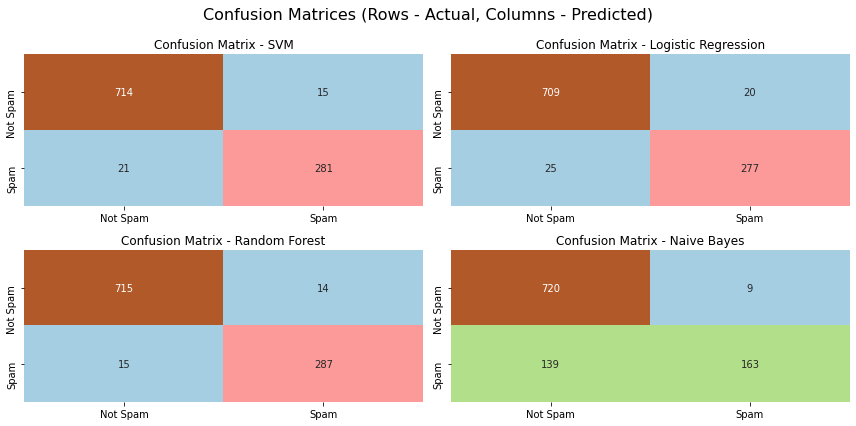

In [14]:
cmat_svm = confusion_matrix(test_l, pred_svm)
cmat_lr = confusion_matrix(test_l, pred_lr)
cmat_rf = confusion_matrix(test_l, pred_rf)
cmat_nb = confusion_matrix(test_l, pred_nb)
fig = plt.figure(figsize=(12,6))
fig.suptitle('Confusion Matrices (Rows - Actual, Columns - Predicted)', fontsize=16);
plt.subplot(2, 2, 1)
plt.title('\n\nConfusion Matrix - SVM')
sns.heatmap(cmat_svm, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.subplot(2, 2, 2)
plt.title('Confusion Matrix - Logistic Regression')
sns.heatmap(cmat_lr, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix - Random Forest')
sns.heatmap(cmat_rf, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix - Naive Bayes')
sns.heatmap(cmat_nb, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.tight_layout()

In [15]:
print('Classification Report - LR:\n', classification_report(test_l, pred_lr),
      '\nClassification Report - SVM:\n', classification_report(test_l, pred_svm),
     '\nClassification Report - RF:\n', classification_report(test_l, pred_rf),
     '\nClassification Report - NB:\n', classification_report(test_l, pred_nb))

Classification Report - LR:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       729
           1       0.93      0.92      0.92       302

    accuracy                           0.96      1031
   macro avg       0.95      0.94      0.95      1031
weighted avg       0.96      0.96      0.96      1031
 
Classification Report - SVM:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       729
           1       0.95      0.93      0.94       302

    accuracy                           0.97      1031
   macro avg       0.96      0.95      0.96      1031
weighted avg       0.96      0.97      0.96      1031
 
Classification Report - RF:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       729
           1       0.95      0.95      0.95       302

    accuracy                           0.97      1031
   macro avg       0.97      0.97     